# This notebook reconstructs buffers to create additional data
## Ethnologue data cannot be shared freely due to copyright issues

# Setup

In [1]:
#%%px --local
#!/usr/bin/env python
# coding: utf-8
'''
======================================================
Author:  Ömer Özak, 2014 (ozak at smu.edu)
Website: http://omerozak.com
GitHub:  https://github.com/ozak/
======================================================
Construct Fishnet of size X
'''
from __future__ import division
# Parallel
#try:
#    from ipyparallel import Client
#except:
#    from IPython.parallel import Client

## Setup the clients, direct views, and balanced views
#c = Client()
#c.ids
#dview = c[:]
#view = c.load_balanced_view()
#dview.activate()

import sys, os, time
import matplotlib.pyplot as plt
# Math, data
import numpy as np
import pandas as pd
pd.set_option('display.width', 140)

#import pandas.tools.util as tools
# GIS packages
os.environ['USE_PYGEOS'] = '0'
#from osgeo import  ogr, osr, gdal, gdalnumeric
#from gdalconst import *
#from PIL import Image, ImageDraw
#from pyGDsandbox.dataIO import df2dbf, dbf2df
#from rasterstats import zonal_stats
#import shutil, glob
#import pysal as ps
#from pysal.contrib import shapely_ext
#import shapely
from shapely.geometry import Polygon, Point
#from shapely.wkt import loads, dumps
#from shapely.ops import cascaded_union
import pyproj
import georasters as gr
#import hmi
import fiona
import fiona.crs
import geopandas as gp
import geopandas.tools as gpt
gpd = gp
import dask_geopandas
#from geopandas.tools import sjoin
from geopy.distance import great_circle
import geostats

from pyproj import CRS
cea = CRS("ESRI:54034")
wgs84 = CRS("EPSG:4326")

# File packages
#import tarfile
#import gzip

# Graph packages
#import skimage.graph as graph
#from skimage.morphology import watershed
#import networkx as nx

# Econometrics
#import statsmodels.api as sm
#import statsmodels.formula.api as smf
#from patsy import dmatrices

# Various other packages
#from rtree import index     # Indices
#import difflib              # Match text
import isounidecode         # Decode and encode text
#from collections import OrderedDict
import itertools
from functools import reduce

# Paths
path = './'
proot = '../../data/'
pathout = proot + 'Ethnologue/'
pathethno = os.getenv('HOME') + '/DataOthers/GIS/GMI_geodata/v17/lang/'
pathdickens = proot + '../Dickens-EJ-2021/ueab065_replication_files/'
pathcntry = geostats.pathmeasures['Inwater']
pathstats = proot + 'stats/'
pathgraphs = '../../graphs/'

if not os.path.exists(pathout):
    os.mkdir(pathout)

if not os.path.exists(pathstats):
    os.mkdir(pathstats)

if not os.path.exists(pathgraphs):
    os.mkdir(pathgraphs)

/users/ozak/micromamba/envs/GeoPython39env/lib/python3.9/site-packages/libpysal/cg/alpha_shapes.py:39: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def nb_dist(x, y):
/users/ozak/micromamba/envs/GeoPython39env/lib/python3.9/site-packages/libpysal/cg/alpha_shapes.py:165: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def get_faces(triangle):
/users/ozak/micromamb

In [2]:
# Plotting
import matplotlib as mpl
import seaborn as sns
# Setup seaborn
sns.set()

# Mapping
import geoplot as gplt
import geoplot.crs as gcrs
import mapclassify as mc
import textwrap

In [3]:
#%%px --local
def Borders(df1, df2):
    """
    Overlay Intersection operation used in overlay function
    """
    # Spatial Index to create intersections
    idx1, idx2 = df2.sindex.query_bulk(df1.geometry, predicate="intersects", sort=True)
    # Create pairs of geometries in both dataframes to be intersected
    if idx1.size > 0 and idx2.size > 0:
        left = df1.geometry.take(idx1)
        left.reset_index(drop=True, inplace=True)
        right = df2.geometry.take(idx2)
        right.reset_index(drop=True, inplace=True)
        intersections = left.intersection(right)
        poly_ix = intersections.type.isin(["LineString", "MultiLineString"])
        intersections.loc[poly_ix] = intersections[poly_ix]#.buffer(0)

        # only keep actual intersecting geometries
        pairs_intersect = pd.DataFrame({"__idx1": idx1, "__idx2": idx2})
        geom_intersect = intersections

        # merge data for intersecting geometries
        df1 = df1.reset_index(drop=True)
        df2 = df2.reset_index(drop=True)
        dfinter = pairs_intersect.merge(
            df1.drop(df1._geometry_column_name, axis=1),
            left_on="__idx1",
            right_index=True,
        )
        dfinter = dfinter.merge(
            df2.drop(df2._geometry_column_name, axis=1),
            left_on="__idx2",
            right_index=True,
            suffixes=("_1", "_2"),
        )

        return gpd.GeoDataFrame(dfinter, geometry=geom_intersect, crs=df1.crs)
    else:
        return gpd.GeoDataFrame(
            [],
            columns=list(set(df1.columns).union(df2.columns)) + ["__idx1", "__idx2"],
            crs=df1.crs,
        )
    
def _overlay_intersection(df1, df2):
    """
    Overlay Intersection operation used in overlay function
    """
    # Spatial Index to create intersections
    idx1, idx2 = df2.sindex.query_bulk(df1.geometry, predicate="intersects", sort=True)
    # Create pairs of geometries in both dataframes to be intersected
    if idx1.size > 0 and idx2.size > 0:
        left = df1.geometry.take(idx1)
        left.reset_index(drop=True, inplace=True)
        right = df2.geometry.take(idx2)
        right.reset_index(drop=True, inplace=True)
        intersections = left.intersection(right)
        poly_ix = intersections.geom_type.isin(["Polygon", "MultiPolygon"])
        intersections.loc[poly_ix] = intersections[poly_ix].buffer(0)

        # only keep actual intersecting geometries
        pairs_intersect = pd.DataFrame({"__idx1": idx1, "__idx2": idx2})
        geom_intersect = intersections

        # merge data for intersecting geometries
        df1 = df1.reset_index(drop=True)
        df2 = df2.reset_index(drop=True)
        dfinter = pairs_intersect.merge(
            df1.drop(df1._geometry_column_name, axis=1),
            left_on="__idx1",
            right_index=True,
        )
        dfinter = dfinter.merge(
            df2.drop(df2._geometry_column_name, axis=1),
            left_on="__idx2",
            right_index=True,
            suffixes=("_1", "_2"),
        )

        return gp.GeoDataFrame(dfinter, geometry=geom_intersect, crs=df1.crs)
    else:
        result = df1.iloc[:0].merge(
            df2.iloc[:0].drop(df2.geometry.name, axis=1),
            left_index=True,
            right_index=True,
            suffixes=("_1", "_2"),
        )
        result["__idx1"] = None
        result["__idx2"] = None
        return result[
            result.columns.drop(df1.geometry.name).tolist() + [df1.geometry.name]
        ]

In [4]:
# Drop repeated pairs
def drop_repeated(df, cols):
    df1 = df[cols].copy()
    df1['reps'] = df1.apply(lambda x: list(set(x[cols].astype(str))), axis=1)
    df1['reps'] = df1.reps.apply(lambda x: '-'.join(x))
    df1 = df1.drop_duplicates('reps')
    df1 = df1.drop('reps', axis=1).reset_index(drop=True)
    return df1

<div class="alert alert-block alert-info", >
    <center><H1>Using Original Data</H1>
</div>

# Import original replication files provided with paper
* We import only shapefiles to show construction and difference/similarity. 
* We import only the file for the 50km buffer (i.e., the 100km diameter)

## Main original replication data file with all pairwise data based on buffers of 50kms

In [5]:
dfor = pd.read_stata(pathdickens + 'Data/EJ_Dickens_Border_100km.dta')
dfor

/tmp/ipykernel_2943607/3197352363.py:1: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  dfor = pd.read_stata(pathdickens + 'Data/EJ_Dickens_Border_100km.dta')


identifier   langName_ethno1 langIso1 country1      family1    langName_ethno2 langIso2 country2       family2  lingDist  ...  \
0      AAA-NGA-EMA-NGA            Ghotuo      aaa  Nigeria  Niger-Congo    Emai-Iuleha-Ora      ema  Nigeria   Niger-Congo  0.459362  ...   
1      AAA-NGA-OKE-NGA            Ghotuo      aaa  Nigeria  Niger-Congo               Okpe      oke  Nigeria   Niger-Congo  0.628569  ...   
2      AAB-NGA-JID-NGA        Alumu-Tesu      aab  Nigeria  Niger-Congo                 Bu      jid  Nigeria   Niger-Congo  0.833333  ...   
3      AAB-NGA-RIN-NGA        Alumu-Tesu      aab  Nigeria  Niger-Congo              Nungu      rin  Nigeria   Niger-Congo       NaN  ...   
4      AAB-NGA-TDV-NGA        Alumu-Tesu      aab  Nigeria  Niger-Congo               Toro      tdv  Nigeria   Niger-Congo  0.532142  ...   
...                ...               ...      ...      ...          ...                ...      ...      ...           ...       ...  ...   
15598  ZYN-CHN-YUE-CHN   Zhuang, Yongnan      zyn    China    Tai-Kadai       Chinese, Yue      yue    China  Sino-Tibetan  0.813015  ...   
15599  ZZJ-CHN-CMN-CHN  Zhuang, Zuojiang      zzj    China    Tai-Kadai  Chinese, Mandarin      cmn    China  Sino-Tibetan  0.865388  ...   
15600  ZZJ-CHN-IUM-CHN  Zhuang, Zuojiang      zzj    China    Tai-Kadai            Iu Mien      ium    China    Hmong-Mien  0.844456  ...   
15601  ZZJ-CHN-TYZ-VNM  Zhuang, Zuojiang      zzj    China    Tai-Kadai                Tay      tyz  Vietnam     Tai-Kadai  0.528902  ...   
15602  ZZJ-CHN-ZYN-CHN  Zhuang, Zuojiang      zzj    China    Tai-Kadai    Zhuang, Yongnan      zyn    China     Tai-Kadai  0.452969  ...   

       langIso_ethno2  langIso_asjp1  langIso_asjp2           langName_asjp1           langName_asjp2  \
0                 ema            aaa            ema                   GHOTUO                     AOMA   
1                 oke            aaa            oke                   GHOTUO                     OKPE   
2                 jid            aab            jid                     TESU               BU_NIGERIA   
3                 rin            aab            rin                     TESU                  missing   
4                 tdv            aab            tdv                     TESU                     TORO   
...               ...            ...            ...                      ...                      ...   
15598             yue            zyn            yue  NINGMING_YONGNAN_ZHUANG                CANTONESE   
15599             cmn            zzj            cmn          LONGZHOU_ZHUANG         KUNMING_MANDARIN   
15600             ium            zzj            ium          LONGZHOU_ZHUANG           CHIANGRAI_MIEN   
15601             tyz            zzj            tyz          LONGZHOU_ZHUANG                      TAY   
15602             zyn            zzj            zyn          LONGZHOU_ZHUANG  NINGMING_YONGNAN_ZHUANG   

                                             familyTree1                                        familyTree2  ccode1  ccode2  region  
0      Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...  Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...   566.0   566.0  Africa  
1      Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...  Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...   566.0   566.0  Africa  
2      Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...  Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...   566.0   566.0  Africa  
3      Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...  Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...   566.0   566.0  Africa  
4      Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...  Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...   566.0   566.0  Africa  
...                                                  ...                                                ...     ...     ...     ...  
15598       Tai-Kadai,Kam-Tai,Be-Tai,Tai-Sek,Tai,Central                               Sino-Tibetan,Chinese   156.0   15

In [6]:
dfor.loc[dfor.identifier=='SPA-MEX-SPA-GTM']

Empty DataFrame
Columns: [identifier, langName_ethno1, langIso1, country1, family1, langName_ethno2, langIso2, country2, family2, lingDist, csi, csi_change, csi_sd, csi_change_sd, elev, elev_sd, elev_range, prec, prec_sd, prec_range, temp, temp_sd, temp_range, malaria, malaria_sd, malaria_range, dist_coast, dist_lake, dist_rivmaj, dist_rivmin, dist_border, dist_pre600, dist_pre1800, dist_lang, ldist_coast, ldist_lake, ldist_rivmaj, ldist_rivmin, ldist_border, ldist_lang, ldist_pre600, ldist_pre1800, asia, africa, europe, oceania, americas, oldworld, nativePop50, nativePop25, nativePop75, nativePopShare1, nativePopShare2, latitude, longitude, langLat1, langLon1, langLat2, langLon2, langLat_diff, langLon_diff, langPop1, langPop2, ln_langPop, langPop_diff, langArea1, langArea2, ln_langArea, langArea_diff, area, larea, branch1, branch2, branch3, branch4, branch5, branch6, branch7, branch8, branch9, branch10, branch11, branch12, branch13, branch14, overlap, sibling, samecountry, langID1, langID2, langIso_ethno1, langIso_ethno2, langIso_asjp1, langIso_asjp2, langName_asjp1, langName_asjp2, familyTree1, familyTree2, ccode1, ccode2, ...]
Index: []

[0 rows x 101 columns]

In [7]:
dfor.loc[dfor.identifier=='SPA-GTM-SPA-MEX']

Empty DataFrame
Columns: [identifier, langName_ethno1, langIso1, country1, family1, langName_ethno2, langIso2, country2, family2, lingDist, csi, csi_change, csi_sd, csi_change_sd, elev, elev_sd, elev_range, prec, prec_sd, prec_range, temp, temp_sd, temp_range, malaria, malaria_sd, malaria_range, dist_coast, dist_lake, dist_rivmaj, dist_rivmin, dist_border, dist_pre600, dist_pre1800, dist_lang, ldist_coast, ldist_lake, ldist_rivmaj, ldist_rivmin, ldist_border, ldist_lang, ldist_pre600, ldist_pre1800, asia, africa, europe, oceania, americas, oldworld, nativePop50, nativePop25, nativePop75, nativePopShare1, nativePopShare2, latitude, longitude, langLat1, langLon1, langLat2, langLon2, langLat_diff, langLon_diff, langPop1, langPop2, ln_langPop, langPop_diff, langArea1, langArea2, ln_langArea, langArea_diff, area, larea, branch1, branch2, branch3, branch4, branch5, branch6, branch7, branch8, branch9, branch10, branch11, branch12, branch13, branch14, overlap, sibling, samecountry, langID1, langID2, langIso_ethno1, langIso_ethno2, langIso_asjp1, langIso_asjp2, langName_asjp1, langName_asjp2, familyTree1, familyTree2, ccode1, ccode2, ...]
Index: []

[0 rows x 101 columns]

In [8]:
dfor.loc[dfor.identifier=='AAA-NGA-EMA-NGA']

identifier langName_ethno1 langIso1 country1      family1  langName_ethno2 langIso2 country2      family2  lingDist  ...  \
0  AAA-NGA-EMA-NGA          Ghotuo      aaa  Nigeria  Niger-Congo  Emai-Iuleha-Ora      ema  Nigeria  Niger-Congo  0.459362  ...   

   langIso_ethno2  langIso_asjp1  langIso_asjp2  langName_asjp1  langName_asjp2                                        familyTree1  \
0             ema            aaa            ema          GHOTUO            AOMA  Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...   

                                         familyTree2  ccode1  ccode2  region  
0  Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...   566.0   566.0  Africa  

[1 rows x 101 columns]

In [9]:
dfor.loc[dfor.identifier=='EMA-NGA-AAA-NGA']

Empty DataFrame
Columns: [identifier, langName_ethno1, langIso1, country1, family1, langName_ethno2, langIso2, country2, family2, lingDist, csi, csi_change, csi_sd, csi_change_sd, elev, elev_sd, elev_range, prec, prec_sd, prec_range, temp, temp_sd, temp_range, malaria, malaria_sd, malaria_range, dist_coast, dist_lake, dist_rivmaj, dist_rivmin, dist_border, dist_pre600, dist_pre1800, dist_lang, ldist_coast, ldist_lake, ldist_rivmaj, ldist_rivmin, ldist_border, ldist_lang, ldist_pre600, ldist_pre1800, asia, africa, europe, oceania, americas, oldworld, nativePop50, nativePop25, nativePop75, nativePopShare1, nativePopShare2, latitude, longitude, langLat1, langLon1, langLat2, langLon2, langLat_diff, langLon_diff, langPop1, langPop2, ln_langPop, langPop_diff, langArea1, langArea2, ln_langArea, langArea_diff, area, larea, branch1, branch2, branch3, branch4, branch5, branch6, branch7, branch8, branch9, branch10, branch11, branch12, branch13, branch14, overlap, sibling, samecountry, langID1, langID2, langIso_ethno1, langIso_ethno2, langIso_asjp1, langIso_asjp2, langName_asjp1, langName_asjp2, familyTree1, familyTree2, ccode1, ccode2, ...]
Index: []

[0 rows x 101 columns]

# Shapefiles for figure 1, which shows the buffer construction

In [10]:
africa_or = gp.read_file(pathdickens + 'ShapeFiles/Fig1/Africa_Country_Borders.shp')
border_or = gp.read_file(pathdickens + 'ShapeFiles/Fig1/Border.shp')
manyika_or = gp.read_file(pathdickens + 'ShapeFiles/Fig1/Manyika.shp')
shona_or = gp.read_file(pathdickens + 'ShapeFiles/Fig1/Shona.shp')
buffer_or = gp.read_file(pathdickens + 'ShapeFiles/Fig1/Shona_Manyika_Buffer.shp')

## Verify which CRS they have

In [11]:
africa_or.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [12]:
border_or.crs

<Derived Projected CRS: ESRI:54052>
Name: World_Goode_Homolosine_Land
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Interrupted Goode Homolosine
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [13]:
manyika_or.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [14]:
shona_or.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [15]:
buffer_or.crs

<Derived Projected CRS: ESRI:54052>
Name: World_Goode_Homolosine_Land
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Interrupted Goode Homolosine
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Concatenate both ethnic groups for plotting

<AxesSubplot:>

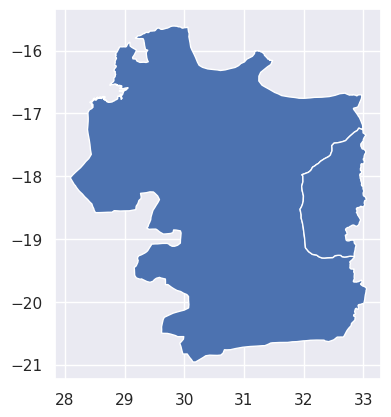

In [16]:
ethn_or = pd.concat([shona_or, manyika_or])
ethn_or.plot()

## Reproject everything to same projection

In [17]:
buffer_or['NAM_LABEL'] = 'Buffer zone (100 km)'
border_or['NAM_LABEL'] = 'Shona-Mankiya Border'

In [18]:
buffer_or_wgs84 = buffer_or.to_crs(shona_or.crs) 
border_or_wgs84 = border_or.to_crs(shona_or.crs) 

In [19]:
border_or_wgs84_buf = border_or_wgs84.copy()
border_or_wgs84_buf.geometry = border_or_wgs84_buf.geometry.buffer(0.01)

/tmp/ipykernel_1381663/3197058390.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  border_or_wgs84_buf.geometry = border_or_wgs84_buf.geometry.buffer(0.01)


## Replicate Figure 1 
### No code provided for comparison, we do not know the underlying projection
### Basic map, we do not make nice legend

In [20]:
extent = pd.DataFrame([ethn_or.total_bounds,
                       buffer_or_wgs84.total_bounds,
                       border_or_wgs84.total_bounds,
                      ], columns=['xmin', 'ymin', 'xmax', 'ymax'])
xmin = extent['xmin'].min() - 1
ymin = extent['ymin'].min() - 1
xmax = extent['xmax'].max() + 1
ymax = extent['ymax'].max() + 1
extent = [xmin, ymin, xmax, ymax]

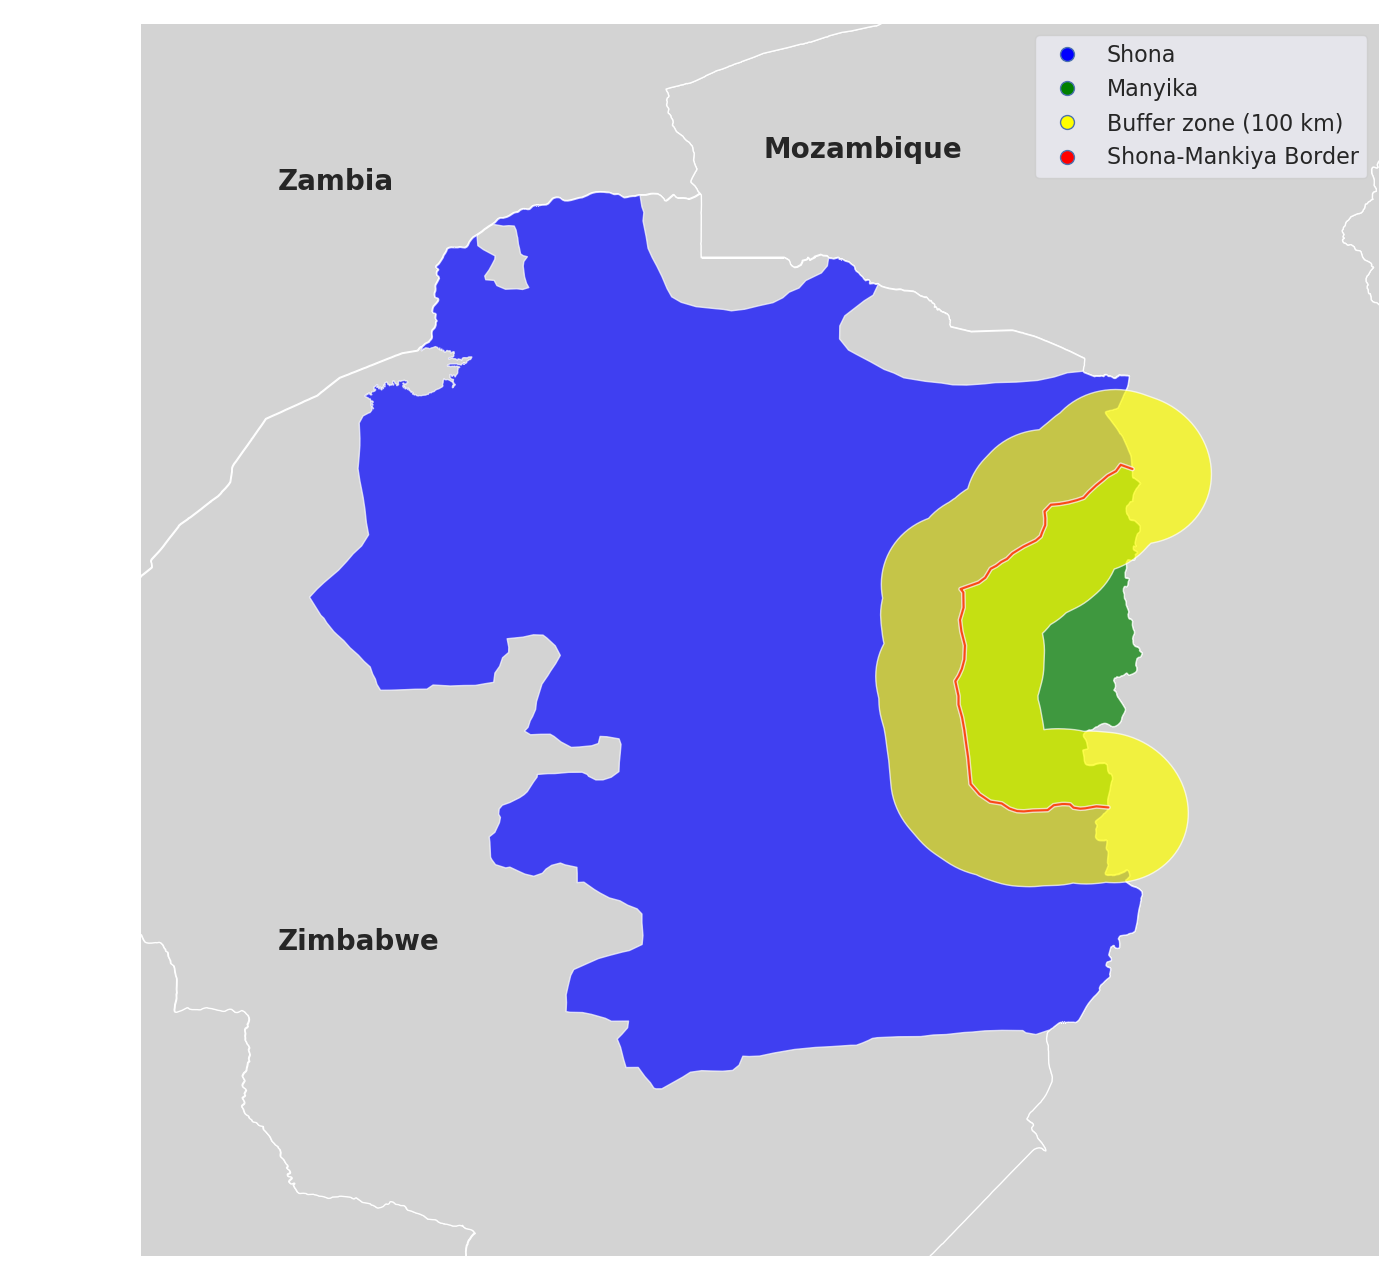

In [21]:
cmap = mpl.colors.ListedColormap(['blue', 'green', 'yellow', 'red'])
dfmap = pd.concat([ethn_or, buffer_or_wgs84, border_or_wgs84_buf]).reset_index()

# Retrieve unique labels
labels = dfmap['NAM_LABEL'].unique()

# Create categorical data type
from pandas.api.types import CategoricalDtype
cat_type = CategoricalDtype(categories=labels, ordered=True)

# Convert 'NAM_LABEL' column to categorical
dfmap['NAM_LABEL_fac'] = dfmap['NAM_LABEL'].astype(cat_type).cat.codes

ax = gplt.choropleth(
        dfmap, hue='NAM_LABEL_fac',
        projection=gcrs.PlateCarree(central_longitude=0.0, globe=None),
        edgecolor=None, linewidth=1, 
        legend=True,
        legend_kwargs={'fontsize':16},
        cmap=cmap,
        figsize=(24, 16),
        scheme = mc.UserDefined(dfmap['NAM_LABEL_fac'], bins=dfmap['NAM_LABEL_fac'].tolist()),
        legend_labels=dfmap['NAM_LABEL'].tolist(),
        rasterized=True,
        alpha=0.7#[[0.5, 1, 1, 1]]
    )
gplt.polyplot(
        africa_or, projection=gcrs.PlateCarree(central_longitude=0.0, globe=None),
        edgecolor='white', facecolor='lightgray',
        ax=ax,
        extent=extent,
    )
plt.annotate(text='Zimbabwe', xy=[0.2, 0.25], xycoords='subfigure fraction', size=20, weight='bold')
plt.annotate(text='Zambia', xy=[0.2, 0.85], xycoords='subfigure fraction', size=20, weight='bold')
plt.annotate(text='Mozambique', xy=[0.55, 0.875], xycoords='subfigure fraction', size=20, weight='bold')
plt.savefig(pathgraphs + 'figure-1-original-data.pdf', dpi=300, bbox_inches='tight')

Text(0.55, 0.875, 'Mozambique')

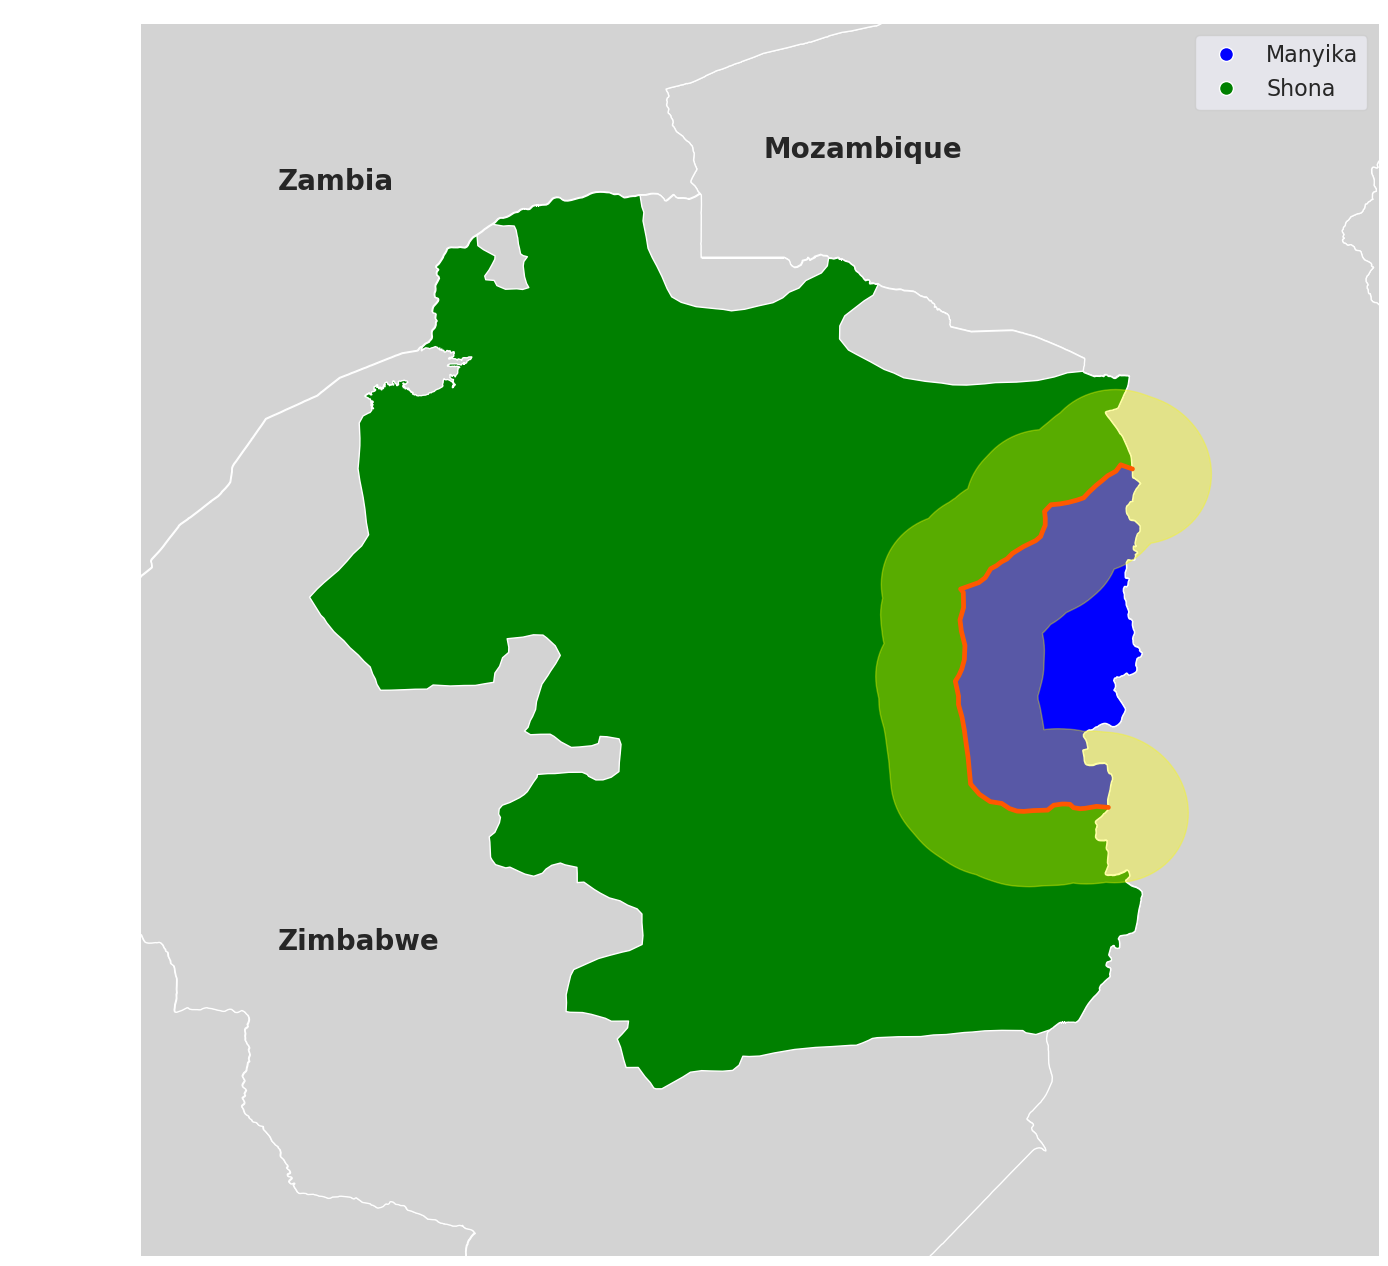

In [22]:
cmap = mpl.colors.ListedColormap(['blue', 'green'])
ax = gplt.choropleth(
        ethn_or, hue='NAM_LABEL', projection=gcrs.PlateCarree(central_longitude=0.0, globe=None),
        edgecolor='white', linewidth=1,
        legend=True,
        legend_kwargs={'fontsize':16},
        cmap=cmap,
        figsize=(24, 16),
        #ax=ax,
        rasterized=True,
    )
gplt.choropleth(
        border_or_wgs84_buf, hue='NAM_LABEL', projection=gcrs.PlateCarree(central_longitude=0.0, globe=None),
        edgecolor='red', linewidth=1,
        #legend=True,
        color='red', alpha=1,
        #figsize=(24, 16),
        ax=ax,
        extent=extent,
    )
gplt.choropleth(
        buffer_or_wgs84, hue='NAM_LABEL', projection=gcrs.PlateCarree(central_longitude=0.0, globe=None),
        edgecolor='yellow', linewidth=1,
        #legend=True,
        color='yellow', alpha=0.35,
        ax=ax
    )
gplt.polyplot(
        africa_or, projection=gcrs.PlateCarree(central_longitude=0.0, globe=None),
        edgecolor='white', facecolor='lightgray',
        ax=ax,
        extent=extent,
    )
plt.annotate(text='Zimbabwe', xy=[0.2, 0.25], xycoords='subfigure fraction', size=20, weight='bold')
plt.annotate(text='Zambia', xy=[0.2, 0.85], xycoords='subfigure fraction', size=20, weight='bold')
plt.annotate(text='Mozambique', xy=[0.55, 0.875], xycoords='subfigure fraction', size=20, weight='bold')
#plt.savefig(pathgraphs + 'figure-1-original-data.pdf', dpi=300, bbox_inches='tight')

<div class="alert alert-block alert-info", >
    <center><H1>Main Replication</H1>
</div>

<div class="alert alert-block alert-info", >
    <center><H1>New Data</H1>
</div>

# Create borders and buffers using full dataset from Ethnologue 17 edition (paper uses version 16)
## Import data & reproject to CEA

In [21]:
ethno = gp.read_file(pathethno + 'langa.shp')
#ethno = ethno.to_crs(cea)
#ethno['key'] = 0
ethno.head()

ID ID_ISO_A3 ID_ISO_A2 ID_FIPS   NAM_LABEL   NAME_PROP       NAME2    NAM_ANSI       CNT                  C1        POP  \
0  RUS-RUS   rus-RUS    rus-ru  rus-RS     Russian     Russian     RUSSIAN     Russian    Europe  Russian Federation  137000000   
1  ENG-USA   eng-USA    eng-us  eng-US     English     English     ENGLISH     English  Americas       United States  225000000   
2  POR-BRA   por-BRA    por-br  por-BR  Portuguese  Portuguese  PORTUGUESE  Portuguese  Americas              Brazil  187000000   
3  ENG-AUS   eng-AUS    eng-au  eng-AS     English     English     ENGLISH     English   Pacific           Australia   15600000   
4  ENG-CAN   eng-CAN    eng-ca  eng-CA     English     English     ENGLISH     English  Americas              Canada   19400000   

      LMP_POP1                                                  G LMP_CLASS     FAMILYPROP         FAMILY              LMP_C1 LANG_ISO  \
0  137000000.0                        Indo-European, Slavic, East         L  Indo-European  INDO-EUROPEAN  Russian Federation      rus   
1  225000000.0             Indo-European, Germanic, West, English         L  Indo-European  INDO-EUROPEAN       United States      eng   
2  187000000.0  Indo-European, Italic, Romance, Italo-Western,...         L  Indo-European  INDO-EUROPEAN              Brazil      por   
3   15600000.0             Indo-European, Germanic, West, English         L  Indo-European  INDO-EUROPEAN           Australia      eng   
4   19400000.0             Indo-European, Germanic, West, English         L  Indo-European  INDO-EUROPEAN              Canada      eng   

  EGIDS                                           geometry  
0     1  MULTIPOLYGON (((34.30387 61.85888, 34.34665 61...  
1     1  MULTIPOLYGON (((-122.52301 47.78182, -122.5395...  
2     1  MULTIPOLYGON (((-52.13058 -31.97901, -52.12447...  
3     1  MULTIPOLYGON (((142.52003 -10.70436, 142.52347...  
4     1  MULTIPOLYGON (((-74.13254 45.52187, -74.11124 ...

In [22]:
ethno = ethno.loc[ethno.LMP_POP1>0].reset_index(drop=True)

In [23]:
ethno.shape

(7388, 20)

# Replicate figure with new data

In [24]:
shona = ethno.loc[(ethno['NAM_LABEL']=='Shona') & (ethno['ID']=='SNA-ZWE')].reset_index()
shona

index       ID ID_ISO_A3 ID_ISO_A2 ID_FIPS NAM_LABEL NAME_PROP  NAME2 NAM_ANSI     CNT  ...       POP    LMP_POP1  \
0    102  SNA-ZWE   sna-ZWE    sna-zw  sna-ZI     Shona     Shona  SHONA    Shona  Africa  ...  10700000  10700000.0   

                                                   G LMP_CLASS   FAMILYPROP       FAMILY    LMP_C1 LANG_ISO EGIDS  \
0  Niger-Congo, Atlantic-Congo, Volta-Congo, Benu...         L  Niger-Congo  NIGER-CONGO  Zimbabwe      sna     3   

                                            geometry  
0  POLYGON ((29.90175 -15.62221, 29.90864 -15.623...  

[1 rows x 21 columns]

In [25]:
manyika = ethno.loc[(ethno['NAM_LABEL']=='Manyika') & (ethno['ID']=='MXC-ZWE')].reset_index()
manyika

index       ID ID_ISO_A3 ID_ISO_A2 ID_FIPS NAM_LABEL NAME_PROP    NAME2 NAM_ANSI     CNT  ...     POP  LMP_POP1  \
0    684  MXC-ZWE   mxc-ZWE    mxc-zw  mxc-ZI   Manyika   Manyika  MANYIKA  Manyika  Africa  ...  861000  861000.0   

                                                   G LMP_CLASS   FAMILYPROP       FAMILY    LMP_C1 LANG_ISO EGIDS  \
0  Niger-Congo, Atlantic-Congo, Volta-Congo, Benu...         L  Niger-Congo  NIGER-CONGO  Zimbabwe      mxc     5   

                                            geometry  
0  POLYGON ((32.99626 -17.25993, 32.99637 -17.265...  

[1 rows x 21 columns]

In [26]:
manyika = manyika.to_crs(cea)
shona = shona.to_crs(cea)
mspair = manyika.merge(shona, how='cross', suffixes=['_1', '_2'])
mspair[['ID_1', 'ID_2']]

ID_1     ID_2
0  MXC-ZWE  SNA-ZWE

In [27]:
mspair['buffer_2'] = mspair.apply(lambda x: x.geometry_1.buffer(50000).intersection(x.geometry_2), axis=1)
mspair['buffer_1'] = mspair.apply(lambda x: x.geometry_2.buffer(50000).intersection(x.geometry_1), axis=1)

<AxesSubplot:>

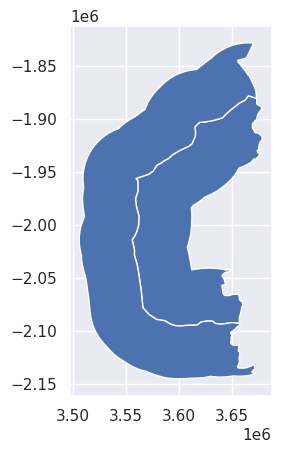

In [28]:
msbuffer = gp.GeoDataFrame(pd.concat([mspair[['ID_1', 'ID_2', 'buffer_1']].rename(columns={'buffer_1':'geometry'}), mspair[['ID_1', 'ID_2', 'buffer_2']].rename(columns={'buffer_2':'geometry'})]), 
                 columns=['ID_1', 'ID_2', 'geometry'],
                 crs=cea, geometry='geometry')
msbuffer.plot()

In [29]:
msbuffer

ID_1     ID_2                                           geometry
0  MXC-ZWE  SNA-ZWE  POLYGON ((3673115.504 -1936845.334, 3671744.96...
0  MXC-ZWE  SNA-ZWE  POLYGON ((3506812.186 -2025072.249, 3505930.19...

In [30]:
msbuffer['NAM_LABEL'] = ['Mankiya Buffer zone (50 km)', 'Shona Buffer zone (50 km)']
msbuffer

ID_1     ID_2                                           geometry                    NAM_LABEL
0  MXC-ZWE  SNA-ZWE  POLYGON ((3673115.504 -1936845.334, 3671744.96...  Mankiya Buffer zone (50 km)
0  MXC-ZWE  SNA-ZWE  POLYGON ((3506812.186 -2025072.249, 3505930.19...    Shona Buffer zone (50 km)

In [31]:
border =  Borders(manyika, shona)
border['NAM_LABEL'] = 'Shona-Mankiya Border'
border

__idx1  __idx2  index_1     ID_1 ID_ISO_A3_1 ID_ISO_A2_1 ID_FIPS_1 NAM_LABEL_1 NAME_PROP_1  NAME2_1  ...  LMP_POP1_2  \
0       0       0      684  MXC-ZWE     mxc-ZWE      mxc-zw    mxc-ZI     Manyika     Manyika  MANYIKA  ...  10700000.0   

                                                 G_2 LMP_CLASS_2  FAMILYPROP_2     FAMILY_2  LMP_C1_2 LANG_ISO_2 EGIDS_2  \
0  Niger-Congo, Atlantic-Congo, Volta-Congo, Benu...           L   Niger-Congo  NIGER-CONGO  Zimbabwe        sna       3   

                                            geometry             NAM_LABEL  
0  MULTILINESTRING ((3657136.373 -2092750.927, 36...  Shona-Mankiya Border  

[1 rows x 44 columns]

In [32]:
shona = shona.to_crs(wgs84)
manyika = manyika.to_crs(wgs84)
border = border.to_crs(wgs84)
msbuffer = msbuffer.to_crs(wgs84)

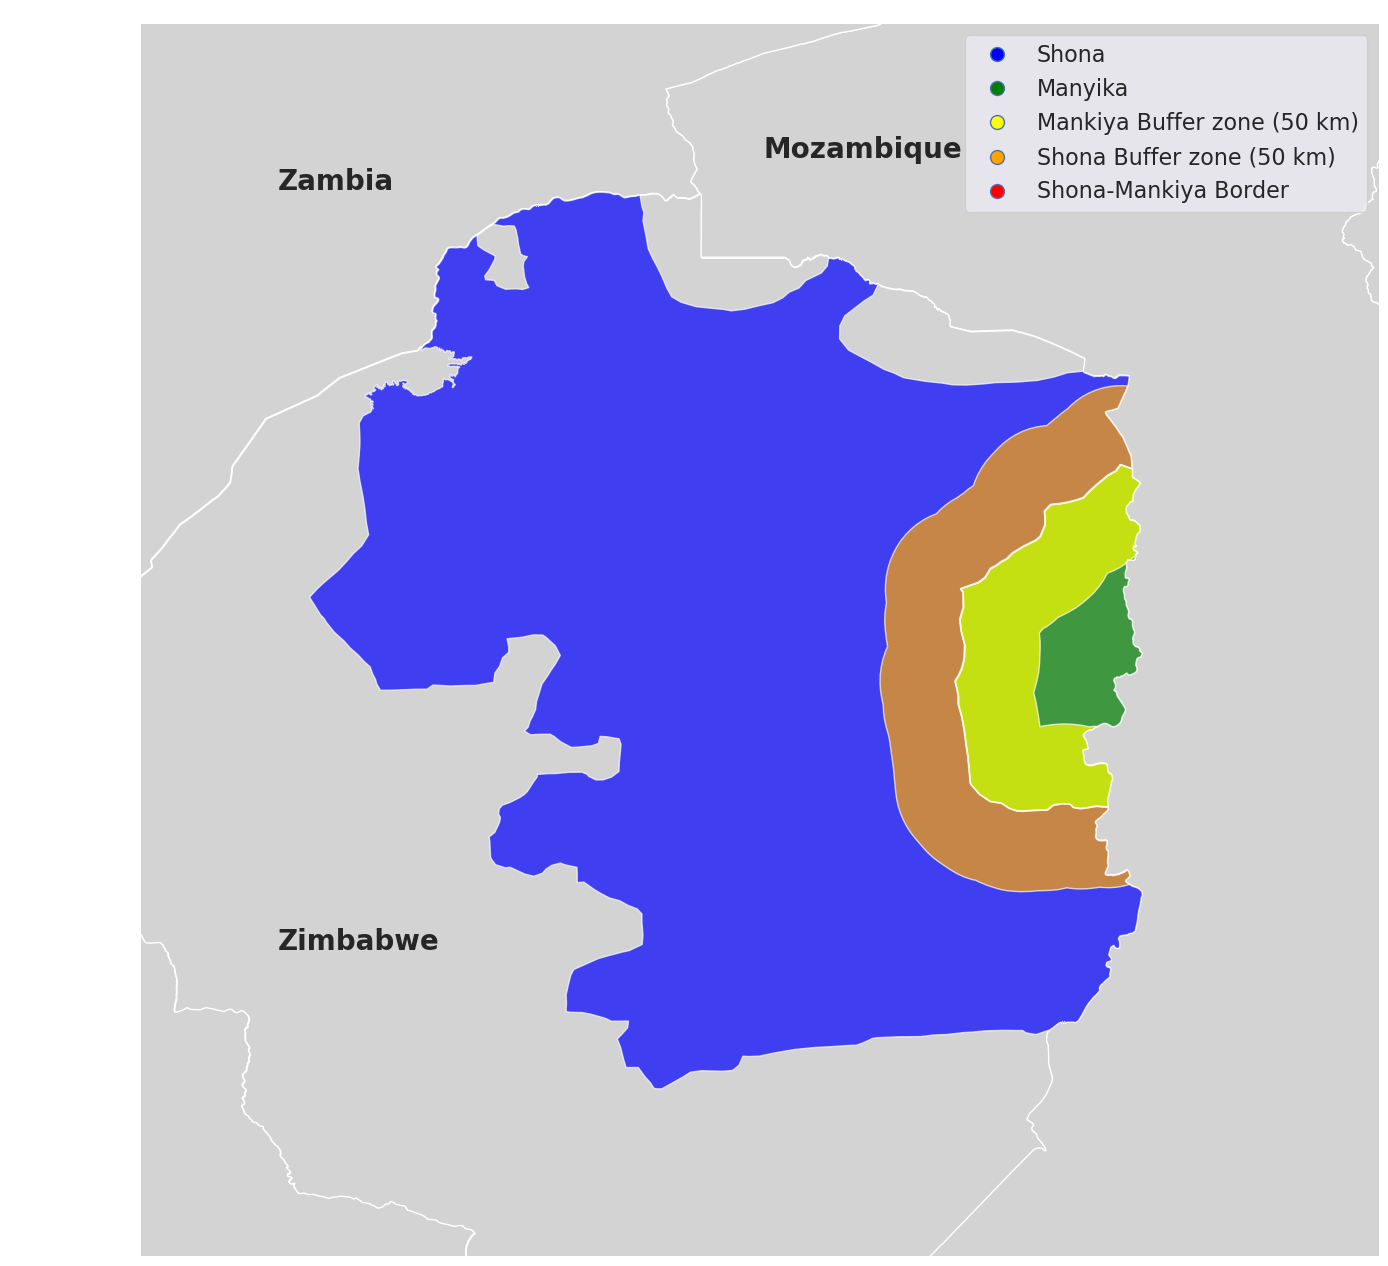

In [33]:
cmap = mpl.colors.ListedColormap(['blue', 'green', 'yellow', 'orange', 'red'])
dfmap = pd.concat([shona, manyika, msbuffer, border]).reset_index()

# Retrieve unique labels
labels = dfmap['NAM_LABEL'].unique()

# Create categorical data type
from pandas.api.types import CategoricalDtype
cat_type = CategoricalDtype(categories=labels, ordered=True)

# Convert 'NAM_LABEL' column to categorical
dfmap['NAM_LABEL_fac'] = dfmap['NAM_LABEL'].astype(cat_type).cat.codes

ax = gplt.choropleth(
        dfmap, hue='NAM_LABEL_fac',
        projection=gcrs.PlateCarree(central_longitude=0.0, globe=None),
        edgecolor=None, linewidth=1, 
        legend=True,
        legend_kwargs={'fontsize':16},
        cmap=cmap,
        figsize=(24, 16),
        scheme = mc.UserDefined(dfmap['NAM_LABEL_fac'], bins=dfmap['NAM_LABEL_fac'].tolist()),
        legend_labels=dfmap['NAM_LABEL'].tolist(),
        rasterized=True,
        alpha=0.7#[[0.5, 1, 1, 1]]
    )
gplt.polyplot(
        africa_or, projection=gcrs.PlateCarree(central_longitude=0.0, globe=None),
        edgecolor='white', facecolor='lightgray',
        ax=ax,
        extent=extent,
    )
plt.annotate(text='Zimbabwe', xy=[0.2, 0.25], xycoords='subfigure fraction', size=20, weight='bold')
plt.annotate(text='Zambia', xy=[0.2, 0.85], xycoords='subfigure fraction', size=20, weight='bold')
plt.annotate(text='Mozambique', xy=[0.55, 0.875], xycoords='subfigure fraction', size=20, weight='bold')
plt.savefig(pathgraphs + 'figure-1-updated-data-alt-buffer-v17.pdf', dpi=300, bbox_inches='tight')

# Create borders and buffers using full dataset from Ethnologue 17 edition (paper uses version 16)

# Find duplicated languages x country
## Is this what Dickens calls the groups occupy non-adjacent regions of a country (fn7)?

In [34]:
ethno.loc[ethno.duplicated('ID')]

ID ID_ISO_A3 ID_ISO_A2 ID_FIPS      NAM_LABEL       NAME_PROP           NAME2        NAM_ANSI     CNT      C1      POP  \
4886  ALN-SRB   aln-SRB    aln-rs  aln-RI  Gheg Albanian  Albanian, Gheg  ALBANIAN, GHEG  Albanian, Gheg  Europe  Serbia  1630000   

       LMP_POP1                              G LMP_CLASS     FAMILYPROP         FAMILY  LMP_C1 LANG_ISO EGIDS  \
4886  1630000.0  Indo-European, Albanian, Gheg         L  Indo-European  INDO-EUROPEAN  Serbia      aln     2   

                                               geometry  
4886  POLYGON ((21.43371 42.77874, 21.43528 42.81889...

## v17 has invalid geometries

In [35]:
ethno.loc[ethno.is_valid==False, 'geometry'] = ethno.loc[ethno.is_valid==False, 'geometry'].buffer(0)

In [36]:
ethno.loc[ethno.is_valid==False]

Empty GeoDataFrame
Columns: [ID, ID_ISO_A3, ID_ISO_A2, ID_FIPS, NAM_LABEL, NAME_PROP, NAME2, NAM_ANSI, CNT, C1, POP, LMP_POP1, G, LMP_CLASS, FAMILYPROP, FAMILY, LMP_C1, LANG_ISO, EGIDS, geometry]
Index: []

## Create all pairs of languages/countries

In [19]:
import multiprocessing
nb_cpus = multiprocessing.cpu_count()
print(nb_cpus)

import dask.dataframe as dd
from dask.distributed import Client, progress
client = Client(processes=True,threads_per_worker=1, n_workers=nb_cpus,memory_limit='64G')

# Create a Dask client to utilize multiple cores
client = Client()
client

128


/users/ozak/micromamba/envs/GeoPython39env/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40753 instead
  warnings.warn(
/users/ozak/micromamba/envs/GeoPython39env/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35833 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:33985' processes=16 threads=128, memory=500.00 GiB>

In [40]:
ddethno = dask_geopandas.from_geopandas(ethno, npartitions=20)
ddethno2 = dask_geopandas.from_geopandas(ethno, npartitions=20)
ddethno['geometry'] = ddethno['geometry'].buffer(0.2)

/users/ozak/micromamba/envs/GeoPython39env/lib/python3.9/site-packages/dask/dataframe/core.py:6699: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return func(*_extract_meta(args, True), **_extract_meta(kwargs, True))


In [41]:
pairs = ddethno.sjoin(ddethno2, predicate="intersects").compute()

/users/ozak/micromamba/envs/GeoPython39env/lib/python3.9/site-packages/dask/utils.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return func(*args, **kwargs)
/users/ozak/micromamba/envs/GeoPython39env/lib/python3.9/site-packages/dask/utils.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return func(*args, **kwargs)
/users/ozak/micromamba/envs/GeoPython39env/lib/python3.9/site-packages/dask/utils.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return func(*args, **kwargs)
/users/ozak/micromamba/envs/GeoPython39env/lib/python3.9/site-packages/dask/utils.py:72: Us

In [42]:
pairs.shape

(75979, 40)

In [43]:
pairs.columns = [c.replace('_left', '_1').replace('_right', '_2') for c in pairs.columns]

In [44]:
pairs.loc[(pairs.ID_1=='MVE-PAK')&(pairs.ID_2=='RWR-IND')]

ID_1 ID_ISO_A3_1 ID_ISO_A2_1 ID_FIPS_1 NAM_LABEL_1 NAME_PROP_1  NAME2_1 NAM_ANSI_1 CNT_1      C1_1  ...   C1_2    POP_2  \
423  MVE-PAK     mve-PAK      mve-pk    mve-PK     Marwari     Marwari  MARWARI    Marwari  Asia  Pakistan  ...  India  5600000   

    LMP_POP1_2                                                G_2 LMP_CLASS_2   FAMILYPROP_2       FAMILY_2 LMP_C1_2 LANG_ISO_2 EGIDS_2  
423  5600000.0  Indo-European, Indo-Iranian, Indo-Aryan, Centr...           L  Indo-European  INDO-EUROPEAN    India        rwr       5  

[1 rows x 40 columns]

In [45]:
pairs = pairs.merge(ethno[['ID', 'geometry']], how='left', left_on='ID_1', right_on='ID', suffixes=['', "_1"])
pairs.head()

ID_1 ID_ISO_A3_1 ID_ISO_A2_1 ID_FIPS_1       NAM_LABEL_1        NAME_PROP_1            NAME2_1         NAM_ANSI_1   CNT_1  \
0  RUS-RUS     rus-RUS      rus-ru    rus-RS           Russian            Russian            RUSSIAN            Russian  Europe   
1  JPN-JPN     jpn-JPN      jpn-jp    jpn-JA          Japanese           Japanese           JAPANESE           Japanese    Asia   
2  RUS-RUS     rus-RUS      rus-ru    rus-RS           Russian            Russian            RUSSIAN            Russian  Europe   
3  CMN-CHN     cmn-CHN      cmn-cn    cmn-CH  Mandarin Chinese  Chinese, Mandarin  CHINESE, MANDARIN  Chinese, Mandarin    Asia   
4  KHK-MNG     khk-MNG      khk-mn    khk-MG    Halh Mongolian    Mongolian, Halh    MONGOLIAN, HALH    Mongolian, Halh    Asia   

                 C1_1  ...   LMP_POP1_2                    G_2 LMP_CLASS_2  FAMILYPROP_2      FAMILY_2 LMP_C1_2 LANG_ISO_2 EGIDS_2  \
0  Russian Federation  ...  121000000.0                Japonic           L       Japonic       JAPONIC    Japan        jpn       1   
1               Japan  ...  121000000.0                Japonic           L       Japonic       JAPONIC    Japan        jpn       1   
2  Russian Federation  ...  840000000.0  Sino-Tibetan, Chinese           L  Sino-Tibetan  SINO-TIBETAN    China        cmn       1   
3               China  ...  840000000.0  Sino-Tibetan, Chinese           L  Sino-Tibetan  SINO-TIBETAN    China        cmn       1   
4            Mongolia  ...  840000000.0  Sino-Tibetan, Chinese           L  Sino-Tibetan  SINO-TIBETAN    China        cmn       1   

        ID                                         geometry_1  
0  RUS-RUS  MULTIPOLYGON (((179.82201 66.03618, 179.94593 ...  
1  JPN-JPN  MULTIPOLYGON (((134.24844 34.70230, 134.25470 ...  
2  RUS-RUS  MULTIPOLYGON (((179.82201 66.03618, 179.94593 ...  
3  CMN-CHN  MULTIPOLYGON (((116.32026 40.72407, 116.42109 ...  
4  KHK-MNG  POLYGON ((99.69989 51.90961, 99.72758 51.90153...  

[5 rows x 42 columns]

In [46]:
pairs['geometry'] = pairs['geometry_1'].values
pairs[['ID_1', 'ID', 'geometry', 'geometry_1']].head()

ID_1       ID                                           geometry                                         geometry_1
0  RUS-RUS  RUS-RUS  MULTIPOLYGON (((179.82201 66.03618, 179.94593 ...  MULTIPOLYGON (((179.82201 66.03618, 179.94593 ...
1  JPN-JPN  JPN-JPN  MULTIPOLYGON (((134.24844 34.70230, 134.25470 ...  MULTIPOLYGON (((134.24844 34.70230, 134.25470 ...
2  RUS-RUS  RUS-RUS  MULTIPOLYGON (((179.82201 66.03618, 179.94593 ...  MULTIPOLYGON (((179.82201 66.03618, 179.94593 ...
3  CMN-CHN  CMN-CHN  MULTIPOLYGON (((116.32026 40.72407, 116.42109 ...  MULTIPOLYGON (((116.32026 40.72407, 116.42109 ...
4  KHK-MNG  KHK-MNG  POLYGON ((99.69989 51.90961, 99.72758 51.90153...  POLYGON ((99.69989 51.90961, 99.72758 51.90153...

In [47]:
pairs = pairs.drop(columns=['ID', 'geometry_1'])

In [48]:
pairs = pairs.to_crs(cea)

In [49]:
pairs = pairs.merge(ethno[['ID', 'geometry']].to_crs(cea), how='left', left_on='ID_2', right_on='ID', suffixes=['_1', "_2"])
pairs[['ID_1', 'ID_2', 'ID', 'geometry_1', 'geometry_2']].head()

ID_1     ID_2       ID                                         geometry_1                                         geometry_2
0  RUS-RUS  JPN-JPN  JPN-JPN  MULTIPOLYGON (((20017694.474 5811022.138, 2003...  MULTIPOLYGON (((14944468.315 3612072.777, 1494...
1  JPN-JPN  JPN-JPN  JPN-JPN  MULTIPOLYGON (((14944468.315 3612072.777, 1494...  MULTIPOLYGON (((14944468.315 3612072.777, 1494...
2  RUS-RUS  CMN-CHN  CMN-CHN  MULTIPOLYGON (((20017694.474 5811022.138, 2003...  MULTIPOLYGON (((12948712.669 4141219.582, 1295...
3  CMN-CHN  CMN-CHN  CMN-CHN  MULTIPOLYGON (((12948712.669 4141219.582, 1295...  MULTIPOLYGON (((12948712.669 4141219.582, 1295...
4  KHK-MNG  CMN-CHN  CMN-CHN  POLYGON ((11098540.987 5000070.539, 11101623.8...  MULTIPOLYGON (((12948712.669 4141219.582, 1295...

In [50]:
%time
pairs = pairs.loc[pairs['ID_1']!=pairs['ID_2']].reset_index(drop=True)
pairs.shape

CPU times: user 13 µs, sys: 0 ns, total: 13 µs
Wall time: 25.3 µs


(68607, 42)

In [51]:
pairs[['ID_1', 'ID_2', 'NAME2_1', 'NAME2_2']].head()

ID_1     ID_2                NAME2_1            NAME2_2
0  RUS-RUS  JPN-JPN                RUSSIAN           JAPANESE
1  RUS-RUS  CMN-CHN                RUSSIAN  CHINESE, MANDARIN
2  KHK-MNG  CMN-CHN        MONGOLIAN, HALH  CHINESE, MANDARIN
3  MVF-CHN  CMN-CHN  MONGOLIAN, PERIPHERAL  CHINESE, MANDARIN
4  KHG-CHN  CMN-CHN         TIBETAN, KHAMS  CHINESE, MANDARIN

## We have dropped all same pair language/countries, now let's drop all same langauge pairs that are in differenct countries
## e.g., SPA-MEX and SPA-GTM
## special case MVE-PAK and RWR-IND are the same language (NAME2) even though they have different ISO codes
## Not clear there is a reason for different ISO code, so we also drop them
### (see https://wikitongues.org/languages/mve/, https://wikitongues.org/languages/rwr/, https://www.ethnologue.com/language/rwr/, https://www.ethnologue.com/language/mve/)

## This differs from Dickens, he seems to keep these

In [52]:
pairs.loc[(pairs['ID_1']=='SPA-MEX')& (pairs['ID_2']=='SPA-GTM')]

ID_1 ID_ISO_A3_1 ID_ISO_A2_1 ID_FIPS_1 NAM_LABEL_1 NAME_PROP_1  NAME2_1 NAM_ANSI_1     CNT_1    C1_1  ...  LMP_POP1_2  \
531  SPA-MEX     spa-MEX      spa-mx    spa-MX     Spanish     Spanish  SPANISH    Spanish  Americas  Mexico  ...   9000000.0   

                                                   G_2 LMP_CLASS_2   FAMILYPROP_2       FAMILY_2   LMP_C1_2 LANG_ISO_2 EGIDS_2       ID  \
531  Indo-European, Italic, Romance, Italo-Western,...           L  Indo-European  INDO-EUROPEAN  Guatemala        spa       1  SPA-GTM   

                                            geometry_2  
531  MULTIPOLYGON (((-9851665.330 1735317.342, -984...  

[1 rows x 42 columns]

In [53]:
pairs = pairs.loc[pairs['NAME2_1']!=pairs['NAME2_2']].reset_index(drop=True)
#pairs = pairs.loc[(pairs['ID_1']!='ALN-SRB') & (pairs['ID_2']!='ALN-SRB')].reset_index(drop=True)
pairs.shape

(67235, 42)

In [54]:
%time
non_repeated_pairs = drop_repeated(pairs, ['ID_1', 'ID_2'])

CPU times: user 6 µs, sys: 7 µs, total: 13 µs
Wall time: 25 µs


In [55]:
non_repeated_pairs

ID_1     ID_2
0      RUS-RUS  JPN-JPN
1      RUS-RUS  CMN-CHN
2      KHK-MNG  CMN-CHN
3      MVF-CHN  CMN-CHN
4      KHG-CHN  CMN-CHN
...        ...      ...
36628  AFN-NGA  NKX-NGA
36629  NKX-NGA  AFN-NGA
36630  BHE-PAK  AEQ-PAK
36631  AEQ-PAK  BHE-PAK
36632  XNB-TWN  SXR-TWN

[36633 rows x 2 columns]

In [56]:
pairs2 = pairs.loc[(pairs.ID_1=='ENG-USA')&(pairs.ID_2=='SPA-MEX')].reset_index()
pairs2[['ID_1', 'ID_2', 'geometry_1', 'geometry_2']]
pairs2['buffer_2'] = pairs2.apply(lambda x: x.geometry_1.buffer(50000).intersection(x.geometry_2), axis=1)
pairs2['buffer_1'] = pairs2.apply(lambda x: x.geometry_2.buffer(50000).intersection(x.geometry_1), axis=1)

<AxesSubplot:>

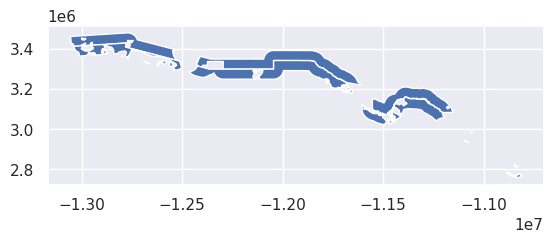

In [57]:
pairs3 = gp.GeoDataFrame(pd.concat([pairs2[['ID_1', 'ID_2', 'buffer_1']].rename(columns={'buffer_1':'geometry'}), pairs2[['ID_1', 'ID_2', 'buffer_2']].rename(columns={'buffer_2':'geometry'})]), 
                 columns=['ID_1', 'ID_2', 'geometry'],
                 crs=cea, geometry='geometry')
pairs3.plot()

<div class="alert alert-block alert-info", >
    <center><H1>New Data - Buffers</H1>
</div>

## Load the pairs from v17 that are actually linked to Dickens

In [58]:
buffersv17 = gp.read_file(pathout + 'Dickens_ethnologue_bordersv17_cyl.json', driver="GeoJSON")

In [59]:
merged_iden = buffersv17[['identifier']].copy()
merged_iden

identifier
0      KHK-MNG-CMN-CHN
1      KHG-CHN-CMN-CHN
2      ADX-CHN-CMN-CHN
3      XAL-CHN-CMN-CHN
4      KAZ-CHN-CMN-CHN
...                ...
13820  MUC-CMR-BOE-CMR
13821  TQL-VUT-URR-VUT
13822  BDX-IDN-TOY-IDN
13823  TUC-PNG-BBV-PNG
13824  AFN-NGA-NKX-NGA

[13825 rows x 1 columns]

In [60]:
pairs.shape

(67235, 42)

In [62]:
pairs['identifier'] = pairs['ID_1'] + '-' + pairs['ID_2']

In [66]:
subpairs = pairs.merge(merged_iden)

In [ ]:
prob = []
for i in range(subpairs.shape[0]):
    try:
        

## We compute buffers and stats only for merged pairs (full sample has issues due to invalid geometries)

In [79]:
def buffer_intersect(row):
    try:
        out1 = row.geometry_1.buffer(50000).buffer(0).intersection(row.geometry_2.buffer(0))
    except:
        out1 = row.identifier
    try:
        out2 = row.geometry_2.buffer(50000).buffer(0).intersection(row.geometry_1.buffer(0))
    except:
        out2 = row.ID_1
    return [out1, out2]

In [84]:
pairs.iloc[10:20].geometry_1.apply(buffer_intersect, axis=1)

10    [MULTIPOLYGON (((14119848.920480538 4676336.04...
11    [MULTIPOLYGON (((12443472.934277562 2804769.43...
12    [MULTIPOLYGON (((12329482.532873858 2646004.25...
13    [MULTIPOLYGON (((13037692.599587351 3233670.24...
14    [POLYGON ((13789081.953173118 4066524.71683114...
15    [MULTIPOLYGON (((11973452.02102267 2378275.360...
16    [MULTIPOLYGON (((10890243.536652457 2700251.14...
17    [MULTIPOLYGON (((12133897.050230002 2921028.93...
18    [MULTIPOLYGON (((11010701.566853492 2720272.47...
19    [MULTIPOLYGON (((11862577.628919119 2938906.11...
dtype: object

In [88]:
ddpairs = dask_geopandas.from_geopandas(pairs, npartitions=20)

In [89]:
ddpairs['geometry_1'] = ddpairs['geometry_1'].apply(lambda x: x.buffer(0), meta=('geometry_1', 'geometry'))
ddpairs['geometry_2'] = ddpairs['geometry_2'].apply(lambda x: x.buffer(0), meta=('geometry_2', 'geometry'))
ddpairs['buffer_2'] = ddpairs.apply(lambda x: x.geometry_1.buffer(0).buffer(50000).intersection(x.geometry_2), axis=1, meta=(None, 'geometry'))
ddpairs['buffer_1'] = ddpairs.apply(lambda x: x.geometry_2.buffer(50000).intersection(x.geometry_1.buffer(0)), axis=1, meta=(None, 'geometry'))
buffers = ddpairs.compute()

/users/ozak/micromamba/envs/GeoPython39env/lib/python3.9/site-packages/dask/dataframe/core.py:4245: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('geometry_1', 'object'))

  warnings.warn(meta_warning(meta))
/users/ozak/micromamba/envs/GeoPython39env/lib/python3.9/site-packages/dask/dataframe/core.py:4245: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  A

In [90]:
buffers[['ID_1', 'ID_2', 'buffer_1', 'buffer_2']]

ID_1     ID_2                                           buffer_1                                           buffer_2
0      RUS-RUS  JPN-JPN  MULTIPOLYGON (((15798275.997472135 4580792.072...  MULTIPOLYGON (((15832575.743105846 4511966.449...
1      RUS-RUS  CMN-CHN  MULTIPOLYGON (((13755709.0257285 5109341.19719...  MULTIPOLYGON (((14776502.06855399 4546876.8010...
2      KHK-MNG  CMN-CHN  POLYGON ((10715363.408863308 4354297.163114779...  POLYGON ((10842561.151102789 4259957.376695122...
3      MVF-CHN  CMN-CHN  MULTIPOLYGON (((10889648.61446669 4301787.6197...  MULTIPOLYGON (((10787585.679967364 4277137.332...
4      KHG-CHN  CMN-CHN  POLYGON ((11314343.319314852 3114405.916329438...  POLYGON ((11388374.26249197 3261457.373360153,...
...        ...      ...                                                ...                                                ...
67230  NKX-NGA  AFN-NGA  POLYGON ((831223.5859426255 502037.7397955065,...  POLYGON ((830847.1449290809 502057.212584235, ...
67231  BHE-PAK  AEQ-PAK  POLYGON ((7734927.60600051 2707613.9355851137,...  POLYGON ((7741831.356025469 2696790.6808052002...
67232  AEQ-PAK  BHE-PAK  POLYGON ((7741831.356025469 2696790.6808052002...  POLYGON ((7734927.60600051 2707613.9355851137,...
67233  XNB-TWN  SXR-TWN  POLYGON ((13457178.135271138 2510337.991613844...  POLYGON ((13437662.826614013 2504109.271347125...
67234  SXR-TWN  XNB-TWN  POLYGON ((13437662.826614013 2504109.271347125...  POLYGON ((13457178.135271138 2510337.991613844...

[67235 rows x 4 columns]

In [91]:
buffers['identifier'] = buffers['ID_1'] + '-' + buffers['ID_2']

In [92]:
buffers1_geo = gp.GeoDataFrame(buffers[['identifier', 'ID_1', 'ID_2', 'buffer_1']], crs=cea, geometry='buffer_1')
buffers1_geo.head()

identifier     ID_1     ID_2                                           buffer_1
0  RUS-RUS-JPN-JPN  RUS-RUS  JPN-JPN  MULTIPOLYGON (((15798275.997 4580792.072, 1580...
1  RUS-RUS-CMN-CHN  RUS-RUS  CMN-CHN  MULTIPOLYGON (((13755709.026 5109341.197, 1375...
2  KHK-MNG-CMN-CHN  KHK-MNG  CMN-CHN  POLYGON ((10715363.409 4354297.163, 10720027.3...
3  MVF-CHN-CMN-CHN  MVF-CHN  CMN-CHN  MULTIPOLYGON (((10889648.614 4301787.620, 1088...
4  KHG-CHN-CMN-CHN  KHG-CHN  CMN-CHN  POLYGON ((11314343.319 3114405.916, 11313568.8...

In [93]:
buffers2_geo = gp.GeoDataFrame(buffers[['identifier', 'ID_1', 'ID_2', 'buffer_2']], crs=cea, geometry='buffer_2')
buffers2_geo.head()

identifier     ID_1     ID_2                                           buffer_2
0  RUS-RUS-JPN-JPN  RUS-RUS  JPN-JPN  MULTIPOLYGON (((15832575.743 4511966.449, 1582...
1  RUS-RUS-CMN-CHN  RUS-RUS  CMN-CHN  MULTIPOLYGON (((14776502.069 4546876.801, 1477...
2  KHK-MNG-CMN-CHN  KHK-MNG  CMN-CHN  POLYGON ((10842561.151 4259957.377, 10837535.4...
3  MVF-CHN-CMN-CHN  MVF-CHN  CMN-CHN  MULTIPOLYGON (((10787585.680 4277137.333, 1078...
4  KHG-CHN-CMN-CHN  KHG-CHN  CMN-CHN  POLYGON ((11388374.262 3261457.373, 11391188.7...

In [94]:
buffers1_geo.to_file(pathout + 'ethnologue_buffers_alt1_v17.json', driver="GeoJSON")
buffers2_geo.to_file(pathout + 'ethnologue_buffers_alt2_v17.json', driver="GeoJSON")

2023-06-10 19:31:51,434 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 22.87 GiB -- Worker memory limit: 31.25 GiB
2023-06-10 19:31:52,796 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 22.59 GiB -- Worker memory limit: 31.25 GiB
2023-06-10 19:32:01,455 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

## No need to recreate overlap etc, we can use what we created in [Replication-Construct-Buffers-Touch-v17.ipynb](./Replication-Construct-Buffers-Touch-v17.ipynb)

<div class="alert alert-block alert-info", >
    <center><H1>New Data - Spatial Stats for New Buffers</H1>
</div>

In [20]:
buffers1_geo = gp.read_file(pathout + 'ethnologue_buffers_alt1_v17.json', driver="GeoJSON")
buffers2_geo = gp.read_file(pathout + 'ethnologue_buffers_alt2_v17.json', driver="GeoJSON")

# Work with CSI data to compute spatial statistics

In [21]:
CSI = os.listdir(proot + 'CSI')

In [22]:
CSI.remove('ReadMe.txt')
CSI.sort()
CSI

['dif2AverageCalories.tif',
 'dif2AverageCalories0.tif',
 'dif2AverageCaloriesNo0.tif',
 'dif2OptCalories.tif',
 'dif2OptCalories0.tif',
 'dif2OptCaloriesNo0.tif',
 'difAverageCalories.tif',
 'difAverageCalories0.tif',
 'difAverageCaloriesNo0.tif',
 'difOptCalories.tif',
 'difOptCalories0.tif',
 'difOptCaloriesNo0.tif',
 'post1500AverageCalories.tif',
 'post1500AverageCalories0.tif',
 'post1500AverageCaloriesNo0.tif',
 'post1500OptCalories.tif',
 'post1500OptCalories0.tif',
 'post1500OptCaloriesNo0.tif',
 'pre15002AverageCalories.tif',
 'pre15002AverageCalories0.tif',
 'pre15002AverageCaloriesNo0.tif',
 'pre15002OptCalories.tif',
 'pre15002OptCalories0.tif',
 'pre15002OptCaloriesNo0.tif',
 'pre1500AverageCalories.tif',
 'pre1500AverageCalories0.tif',
 'pre1500AverageCaloriesNo0.tif',
 'pre1500OptCalories.tif',
 'pre1500OptCalories0.tif',
 'pre1500OptCaloriesNo0.tif']

In [23]:
buffers1_geo = buffers1_geo.to_crs(wgs84)
buffers2_geo = buffers2_geo.to_crs(wgs84)

## Can we use dask?

In [24]:
csi = gr.from_file(proot + '/CSI/' + CSI[3])

In [25]:
buffers1_geo['i'] = buffers1_geo.index.tolist()
buffers1_geo.head()

identifier     ID_1     ID_2                                           geometry  i
0  RUS-RUS-JPN-JPN  RUS-RUS  JPN-JPN  MULTIPOLYGON (((141.91833 46.16705, 141.96464 ...  0
1  RUS-RUS-CMN-CHN  RUS-RUS  CMN-CHN  MULTIPOLYGON (((123.56964 53.52730, 123.57097 ...  1
2  KHK-MNG-CMN-CHN  KHK-MNG  CMN-CHN  POLYGON ((96.25775 43.30235, 96.29964 43.31712...  2
3  MVF-CHN-CMN-CHN  MVF-CHN  CMN-CHN  MULTIPOLYGON (((97.82338 42.65727, 97.81769 42...  3
4  KHG-CHN-CMN-CHN  KHG-CHN  CMN-CHN  POLYGON ((101.63848 29.40999, 101.63152 29.435...  4

In [26]:
buffers1_geo.head().apply(lambda x: x.geometry, axis=1)

0    MULTIPOLYGON (((141.91833 46.16705, 141.96464 ...
1    MULTIPOLYGON (((123.56964 53.52730, 123.57097 ...
2    POLYGON ((96.25775 43.30235, 96.29964 43.31712...
3    MULTIPOLYGON (((97.82338 42.65727, 97.81769 42...
4    POLYGON ((101.63848 29.40999, 101.63152 29.435...
dtype: geometry

In [28]:
intermediate = buffers1_geo.head().apply(lambda x: csi.stats(gp.GeoDataFrame([x], columns=buffers1_geo.columns.tolist(), geometry=[x.geometry], crs=wgs84), add_stats={'median': np.ma.median, 'std': np.ma.std, 'max': np.ma.max, 'min': np.ma.min}, raster_out=False), axis=1)
type(intermediate)

pandas.core.series.Series

In [59]:
pd.concat(buffers1_geo.head().apply(lambda x: csi.stats(gp.GeoDataFrame([x], columns=buffers1_geo.columns.tolist(), geometry=[x.geometry], crs=wgs84), add_stats={'median': np.ma.median, 'std': np.ma.std, 'max': np.ma.max, 'min': np.ma.min}, raster_out=False), axis=1).tolist())


identifier     ID_1     ID_2  i          max  min          std         mean       median
id                                                                                               
0   RUS-RUS-JPN-JPN  RUS-RUS  JPN-JPN  0          0.0  0.0          0.0          0.0          0.0
1   RUS-RUS-CMN-CHN  RUS-RUS  CMN-CHN  1  3623.160645  0.0   902.235166  1534.518801  1518.830566
2   KHK-MNG-CMN-CHN  KHK-MNG  CMN-CHN  2          0.0  0.0          0.0          0.0          0.0
3   MVF-CHN-CMN-CHN  MVF-CHN  CMN-CHN  3  3732.080078  0.0  1052.468711   1081.13138  1147.449951
4   KHG-CHN-CMN-CHN  KHG-CHN  CMN-CHN  4          0.0  0.0          0.0          0.0          0.0

In [71]:
buffers1_geo.head().apply(lambda x: csi.stats(buffers1_geo.loc[[x.i]], add_stats={'median': np.ma.median, 'std': np.ma.std, 'max': np.ma.max, 'min': np.ma.min}, raster_out=False), axis=1)


0             identifier     ID_1     ID_2  i  max ...
1             identifier     ID_1     ID_2  i      ...
2             identifier     ID_1     ID_2  i  max ...
3             identifier     ID_1     ID_2  i      ...
4             identifier     ID_1     ID_2  i  max ...
dtype: object

In [29]:
# Convert buffers1_geo to a Dask DataFrame
ddbuffers1_geo = dd.from_pandas(buffers1_geo, npartitions=8)  # Adjust the number of partitions as needed

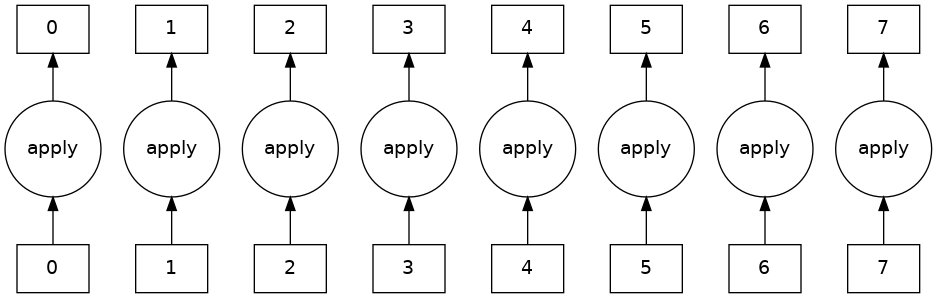

In [34]:
out.visualize()

In [33]:
mycols = buffers1_geo.columns.tolist()
meta_df = pd.Series(dtype='object', name='Column B')
out = ddbuffers1_geo.apply(lambda x: csi.stats(gp.GeoDataFrame([x], columns=buffers1_geo.columns.tolist(), geometry=[x.geometry], crs=wgs84), add_stats={'median': np.ma.median, 'std': np.ma.std, 'max': np.ma.max, 'min': np.ma.min}, raster_out=False), axis=1, meta=meta_df)
out = out.compute()

2023-06-12 11:44:59,573 - distributed.protocol.pickle - ERROR - Failed to serialize <ToPickle: HighLevelGraph with 2 layers.
 0. from_pandas-fb7e02e75442b30a2a3a17dc7d264848
 1. apply-d22f35444934dcdfc8f9e49a710258f8
>.
Traceback (most recent call last):
  File "/users/ozak/micromamba/envs/GeoPython39env/lib/python3.9/site-packages/distributed/protocol/pickle.py", line 63, in dumps
    result = pickle.dumps(x, **dump_kwargs)
_pickle.PicklingError: Can't pickle <function <lambda> at 0x154ff99e03a0>: attribute lookup <lambda> on __main__ failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/users/ozak/micromamba/envs/GeoPython39env/lib/python3.9/site-packages/distributed/protocol/pickle.py", line 68, in dumps
    pickler.dump(x)
_pickle.PicklingError: Can't pickle <function <lambda> at 0x154ff99e03a0>: attribute lookup <lambda> on __main__ failed

During handling of the above exception, another exception occurred:

Traceb

TypeError: ('Could not serialize object of type HighLevelGraph', '<ToPickle: HighLevelGraph with 2 layers.\n<dask.highlevelgraph.HighLevelGraph object at 0x154fe4908b80>\n 0. from_pandas-fb7e02e75442b30a2a3a17dc7d264848\n 1. apply-d22f35444934dcdfc8f9e49a710258f8\n>')

In [20]:
@dask.delayed
def process_file(r):
    print(r.replace('.tif', ''))
    csi = gr.from_file(proot + '/CSI/' + r)
    out = ddbuffers1_geo.apply(lambda x: csi.stats(buffers1_geo.loc[[x.i]], add_stats={'median': np.ma.median, 'std': np.ma.std, 'max': np.ma.max, 'min': np.ma.min}, raster_out=False), axis=1)
    pd.concat(out.tolist())
    
    out = []
    for (i, row) in ddbuffers1_geo.iterrows():
        out.append(dask.delayed(csi.stats)(ddbuffers1_geo.loc[[i]], add_stats={'median': np.ma.median, 'std': np.ma.std, 'max': np.ma.max, 'min': np.ma.min}, raster_out=False))
    out = pd.concat(out)
    out = out.apply(lambda c: c.astype(float) if c.name in out.columns[3:] else c)
    out.columns = ['identifier', 'ID_1', 'ID_2'] + [r.replace('.tif', '') + c for c in out.columns[3:]]
    out.to_stata(pathstats + 'Dickens_ethnologue_v17_' + r.replace('.tif', '') + '_alt.dta', version=117, write_index=False)
    return 0
    
# Convert buffers1_geo to a Dask DataFrame
ddbuffers1_geo = dd.from_pandas(buffers1_geo, npartitions=20)  # Adjust the number of partitions as needed

# Apply the processing function to each file using Dask
processed_files = [process_file(r) for r in CSI[:3]]

# Compute the result
result = dask.compute(processed_files)
result

/users/ozak/micromamba/envs/GeoPython39env/lib/python3.9/site-packages/distributed/client.py:3125: UserWarning: Sending large graph of size 112.42 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/users/ozak/micromamba/envs/GeoPython39env/lib/python3.9/site-packages/distributed/client.py:3125: UserWarning: Sending large graph of size 20.86 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/users/ozak/micromamba/envs/GeoPython39env/lib/python3.9/site-packages/distributed/client.py:3125: UserWarning: Sending large graph of size 20.86 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/users/ozak/micromamba/envs/GeoPython39env/lib/python3.9/site-packages/distributed/client.py:3125: UserWarning: Sending large graph of size 20.86 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using f

TypeError: cannot concatenate object of type '<class 'dask.delayed.Delayed'>'; only Series and DataFrame objs are valid

2023-06-10 21:24:59,522 - distributed.worker - WARNING - Compute Failed
Key:       process_file-9b372897-e0e5-4e3b-9331-9118e2a84d70
Function:  process_file
args:      ('dif2AverageCaloriesNo0.tif')
kwargs:    {}
Exception: 'TypeError("cannot concatenate object of type \'<class \'dask.delayed.Delayed\'>\'; only Series and DataFrame objs are valid")'

2023-06-10 21:25:03,155 - distributed.worker - WARNING - Compute Failed
Key:       process_file-4c7176a7-9659-4cb9-b5e7-e8e85cd87ad3
Function:  process_file
args:      ('dif2AverageCalories0.tif')
kwargs:    {}
Exception: 'TypeError("cannot concatenate object of type \'<class \'dask.delayed.Delayed\'>\'; only Series and DataFrame objs are valid")'



In [11]:
import dask.delayed
import dask.dataframe as dd

@dask.delayed
def process_file(r):
    print(r.replace('.tif', ''))
    csi = gr.from_file(proot + '/CSI/' + r)
    out = []
    for (i, row) in buffers1_geo.head().iterrows():
        out.append(dask.delayed(csi.stats)(ddbuffers1_geo.loc[[i]], add_stats={'median': np.ma.median, 'std': np.ma.std, 'max': np.ma.max, 'min': np.ma.min}, raster_out=False))
    out = dd.from_delayed(dask.delayed(pd.concat)(out))
    #out = out.apply(lambda c: c.astype(float) if c.name in out.columns[3:] else c)
    #out.columns = ['identifier', 'ID_1', 'ID_2'] + [r.replace('.tif', '') + c for c in out.columns[3:]]
    #out.to_stata(pathstats + 'Dickens_ethnologue_v17_' + r.replace('.tif', '') + '_alt.dta', version=117, write_index=False)
    return out

# Convert buffers1_geo to a Dask DataFrame
ddbuffers1_geo = dd.from_pandas(buffers1_geo, npartitions=1)  # Adjust the number of partitions as needed

# Apply the processing function to each file using Dask
processed_files = [process_file(r) for r in CSI[:2]]

# Compute the result
result = dask.compute(processed_files)
result

/users/ozak/micromamba/envs/GeoPython39env/lib/python3.9/site-packages/distributed/client.py:3125: UserWarning: Sending large graph of size 223.35 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/users/ozak/micromamba/envs/GeoPython39env/lib/python3.9/site-packages/libpysal/cg/alpha_shapes.py:39: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def nb_dist(x, y):
/users/ozak/micromamba/envs/GeoPython39env/lib/python3.9/site-packages/libpysal/cg/alpha_shapes.py:39: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is cu

TypeError: ('Could not serialize object of type HighLevelGraph', '<ToPickle: HighLevelGraph with 18 layers.\n<dask.highlevelgraph.HighLevelGraph object at 0x1553eed22f70>\n 0. from_pandas-3193bcd50208d155a008d965a12fa3ce\n 1. loc-d13daa4cd7eba494b89c81b3b31ed085\n 2. finalize-aceb135a-56c4-42cd-8bd7-d14ea360eb8b\n 3. stats-c29160c3-b4c3-48ee-b7a4-067d7d148088\n 4. loc-cee254b710c8ce8c64a5214a9e536df5\n 5. finalize-4f397578-3c89-49e7-a66e-f5bd0d2f26ef\n 6. stats-87f63992-2507-47d2-bf57-b2ad0a8857ae\n 7. loc-809fc9782e84d876b4149d1be5547517\n 8. finalize-80d844ba-4b11-4d57-adb0-5409640ec083\n 9. stats-bbf375a5-1935-4504-ad73-9e6ee804defd\n 10. loc-44b52c7a4610b65c64e39a1960e5680e\n 11. finalize-a698db28-4fef-4485-8102-729f67afbc60\n 12. stats-7ea334ab-08b3-44f3-a10c-073f6abb3b96\n 13. loc-e38b879a8afbe77531dc049dc5ea90fe\n 14. finalize-fb6b138d-235e-4182-827b-cf305048bfa9\n 15. stats-d99647e2-96aa-4432-9918-537db75449c6\n 16. concat-0ee836fe-1ca9-488d-8858-0e9ee97c4999\n 17. make_meta-c5cedebc-a66d-4896-9d9b-a70069cc4c95\n>')

# Unused

## one option

In [14]:
%%timeit
for r in CSI:
    print(r.replace('.tif', ''))
    if os.path.exists(pathstats + 'Dickens_ethnologue_v17_' + r.replace('.tif', '') + '_alt.dta')==False:
        csi = gr.from_file(proot + '/CSI/' + r)
        out = []
        for (i, row) in buffers1_geo.iterrows():
            out.append(csi.stats(buffers1_geo.loc[[i]], add_stats={'median':np.ma.median, 'std':np.ma.std, 'max':np.ma.max, 'min':np.ma.min}, raster_out=False))
        out = pd.concat(out)
        print(out.columns)
        for c in out.columns[3:]:
            out[c] = out[c].astype(float)
        out.columns = ['identifier', 'ID_1', 'ID_2'] + [r.replace('.tif', '') + c for c in out.columns[3:]]
        out.to_stata(pathstats + 'Dickens_ethnologue_v17_' + r.replace('.tif', '') + '_alt.dta', version=117, write_index=False)


dif2AverageCalories
dif2AverageCalories0
dif2AverageCaloriesNo0
dif2OptCalories
dif2OptCalories0
dif2OptCaloriesNo0
difAverageCalories
difAverageCalories0
difAverageCaloriesNo0
difOptCalories
difOptCalories0
difOptCaloriesNo0
post1500AverageCalories
post1500AverageCalories0
post1500AverageCaloriesNo0
post1500OptCalories
post1500OptCalories0
post1500OptCaloriesNo0
pre15002AverageCalories
pre15002AverageCalories0
pre15002AverageCaloriesNo0
pre15002OptCalories
pre15002OptCalories0
pre15002OptCaloriesNo0
pre1500AverageCalories
pre1500AverageCalories0
pre1500AverageCaloriesNo0
pre1500OptCalories
pre1500OptCalories0
pre1500OptCaloriesNo0
dif2AverageCalories
dif2AverageCalories0
dif2AverageCaloriesNo0
dif2OptCalories
dif2OptCalories0
dif2OptCaloriesNo0
difAverageCalories
difAverageCalories0
difAverageCaloriesNo0
difOptCalories
difOptCalories0
difOptCaloriesNo0
post1500AverageCalories
post1500AverageCalories0
post1500AverageCaloriesNo0
post1500OptCalories
post1500OptCalories0
post1500OptCalori

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [15]:
%%timeit
for r in CSI:
    print(r.replace('.tif', ''))
    if os.path.exists(pathstats + 'Dickens_ethnologue_v17_' + r.replace('.tif', '') + '_alt2.dta')==False:
        csi = gr.from_file(proot + '/CSI/' + r)
        out = []
        for (i, row) in buffers2_geo.iterrows():
            out.append(csi.stats(buffers2_geo.loc[[i]], add_stats={'median':np.ma.median, 'std':np.ma.std, 'max':np.ma.max, 'min':np.ma.min}, raster_out=False))
        out = pd.concat(out)
        print(out.columns)
        for c in out.columns[3:]:
            out[c] = out[c].astype(float)
        out.columns = ['identifier', 'ID_1', 'ID_2'] + [r.replace('.tif', '') + c for c in out.columns[3:]]
        out.to_stata(pathstats + 'Dickens_ethnologue_v17_' + r.replace('.tif', '') + '_alt2.dta', version=117, write_index=False)


dif2AverageCalories
Index(['identifier', 'ID_1', 'ID_2', 'median', 'std', 'max', 'mean', 'min'], dtype='object')
dif2AverageCalories0
Index(['identifier', 'ID_1', 'ID_2', 'median', 'std', 'max', 'mean', 'min'], dtype='object')
dif2AverageCaloriesNo0
Index(['identifier', 'ID_1', 'ID_2', 'median', 'std', 'max', 'mean', 'min'], dtype='object')
dif2OptCalories
Index(['identifier', 'ID_1', 'ID_2', 'median', 'std', 'max', 'mean', 'min'], dtype='object')
dif2OptCalories0
Index(['identifier', 'ID_1', 'ID_2', 'median', 'std', 'max', 'mean', 'min'], dtype='object')
difAverageCalories
Index(['identifier', 'ID_1', 'ID_2', 'median', 'std', 'max', 'mean', 'min'], dtype='object')
difAverageCalories0
Index(['identifier', 'ID_1', 'ID_2', 'median', 'std', 'max', 'mean', 'min'], dtype='object')
difAverageCaloriesNo0



KeyboardInterrupt



In [50]:
r = CSI[3]
csi = gr.from_file(proot + '/CSI/' + r)
csi.min()

0.0

In [51]:
csi.projection.ExportToProj4()

'+proj=longlat +datum=WGS84 +no_defs'

In [68]:
buffers1_geo = buffers1_geo.to_crs(wgs84)
buffers2_geo = buffers2_geo.to_crs(wgs84)

In [87]:
out.dtypes

identifier                object
ID_1                      object
ID_2                      object
dif2OptCaloriesmean      float64
dif2OptCaloriesmedian    float64
dif2OptCaloriesmin       float64
dif2OptCaloriesmax       float64
dif2OptCaloriesstd       float64
dtype: object

In [86]:
%%time
out = []
for (i, row) in buffers1_geo.head(100).iterrows():
    out.append(csi.stats(buffers1_geo.loc[[i]], add_stats={'median':np.ma.median, 'std':np.ma.std, 'max':np.ma.max, 'min':np.ma.min}, raster_out=False))
out = pd.concat(out)
for c in out.columns[3:]:
    out[c] = out[c].astype(float)
out.columns = ['identifier', 'ID_1', 'ID_2'] + [r.replace('.tif', '') + c for c in out.columns[3:]]
out.to_stata(pathstats + 'Dickens_ethnologue_v17_' + r.replace('.tif', '') + '.dta', version=117, write_index=False)
out

CPU times: user 1.16 s, sys: 15.3 ms, total: 1.17 s
Wall time: 1.25 s


identifier     ID_1     ID_2  dif2OptCaloriesmean  dif2OptCaloriesmedian  dif2OptCaloriesmin  dif2OptCaloriesmax  \
id                                                                                                                          
0   RUS-RUS-JPN-JPN  RUS-RUS  JPN-JPN             0.000000               0.000000                 0.0            0.000000   
1   RUS-RUS-CMN-CHN  RUS-RUS  CMN-CHN          1075.738215             841.635132                 0.0         3623.160645   
2   KHK-MNG-CMN-CHN  KHK-MNG  CMN-CHN             0.000000               0.000000                 0.0            0.000000   
3   MVF-CHN-CMN-CHN  MVF-CHN  CMN-CHN          1039.935653            1011.455078                 0.0         3732.080078   
4   KHG-CHN-CMN-CHN  KHG-CHN  CMN-CHN             0.000000               0.000000                 0.0            0.000000   
..              ...      ...      ...                  ...                    ...                 ...                 ...   
95  FIN-FIN-SMS-RUS  FIN-FIN  SMS-RUS             0.000000               0.000000                 0.0            0.000000   
96  KRL-RUS-SMS-RUS  KRL-RUS  SMS-RUS            14.420000               0.000000                 0.0          463.539978   
97  SJD-RUS-SMS-RUS  SJD-RUS  SMS-RUS             0.000000               0.000000                 0.0            0.000000   
98  CMN-CHN-RUS-RUS  CMN-CHN  RUS-RUS           964.401512             679.055176                 0.0         3502.140137   
99  SAH-RUS-RUS-RUS  SAH-RUS  RUS-RUS             0.000000               0.000000                 0.0            0.000000   

    dif2OptCaloriesstd  
id                      
0             0.000000  
1           989.858223  
2             0.000000  
3          1033.888391  
4             0.000000  
..                 ...  
95            0.000000  
96           75.582044  
97            0.000000  
98          905.127783  
99            0.000000  

[100 rows x 8 columns]

In [78]:
out = pd.concat(out)

identifier     ID_1     ID_2         mean       median  min          max          std
id                                                                                            
0   RUS-RUS-JPN-JPN  RUS-RUS  JPN-JPN          0.0          0.0  0.0          0.0          0.0
1   RUS-RUS-CMN-CHN  RUS-RUS  CMN-CHN  1075.738215   841.635132  0.0  3623.160645   989.858223
2   KHK-MNG-CMN-CHN  KHK-MNG  CMN-CHN          0.0          0.0  0.0          0.0          0.0
3   MVF-CHN-CMN-CHN  MVF-CHN  CMN-CHN  1039.935653  1011.455078  0.0  3732.080078  1033.888391
4   KHG-CHN-CMN-CHN  KHG-CHN  CMN-CHN          0.0          0.0  0.0          0.0          0.0
..              ...      ...      ...          ...          ...  ...          ...          ...
95  FIN-FIN-SMS-RUS  FIN-FIN  SMS-RUS          0.0          0.0  0.0          0.0          0.0
96  KRL-RUS-SMS-RUS  KRL-RUS  SMS-RUS        14.42          0.0  0.0   463.539978    75.582044
97  SJD-RUS-SMS-RUS  SJD-RUS  SMS-RUS          0.0          0.0  0.0          0.0          0.0
98  CMN-CHN-RUS-RUS  CMN-CHN  RUS-RUS   964.401512   679.055176  0.0  3502.140137   905.127783
99  SAH-RUS-RUS-RUS  SAH-RUS  RUS-RUS          0.0          0.0  0.0          0.0          0.0

[100 rows x 8 columns]

In [61]:
%%time
csi.stats(manyika.loc[[0]], add_stats={'median':np.ma.median, 'std':np.ma.std, 'max':np.ma.max, 'min':np.ma.min}, raster_out=False)

CPU times: user 25.7 ms, sys: 4.57 ms, total: 30.3 ms
Wall time: 28.6 ms


index       ID ID_ISO_A3 ID_ISO_A2 ID_FIPS NAM_LABEL NAME_PROP    NAME2 NAM_ANSI     CNT  ... LMP_CLASS   FAMILYPROP       FAMILY  \
id                                                                                           ...                                       
0    671  MXC-ZWE   mxc-ZWE    mxc-zw  mxc-ZI   Manyika   Manyika  MANYIKA  Manyika  Africa  ...         L  Niger-Congo  NIGER-CONGO   

      LMP_C1 LANG_ISO         mean      median  min          max          std  
id                                                                             
0   Zimbabwe      mxc  3062.561136  3733.44043  0.0  8092.129883  2503.293893  

[1 rows x 24 columns]